In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

df_data = pd.read_csv('breast_cancer_modified.csv')
df_data.head()

Saving breast_cancer_modified.csv to breast_cancer_modified.csv


,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


# Visualization

Diagnosis Distribution:
B    357
M    212
Name: Diagnosis, dtype: int64


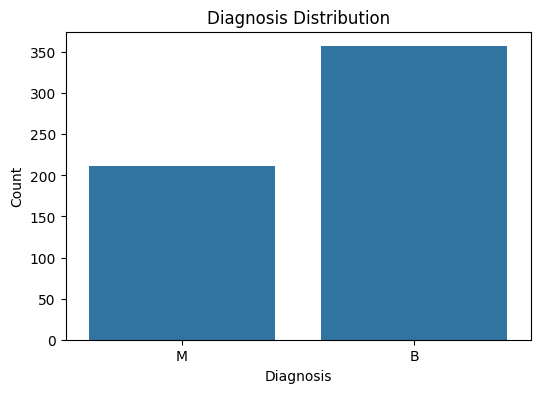

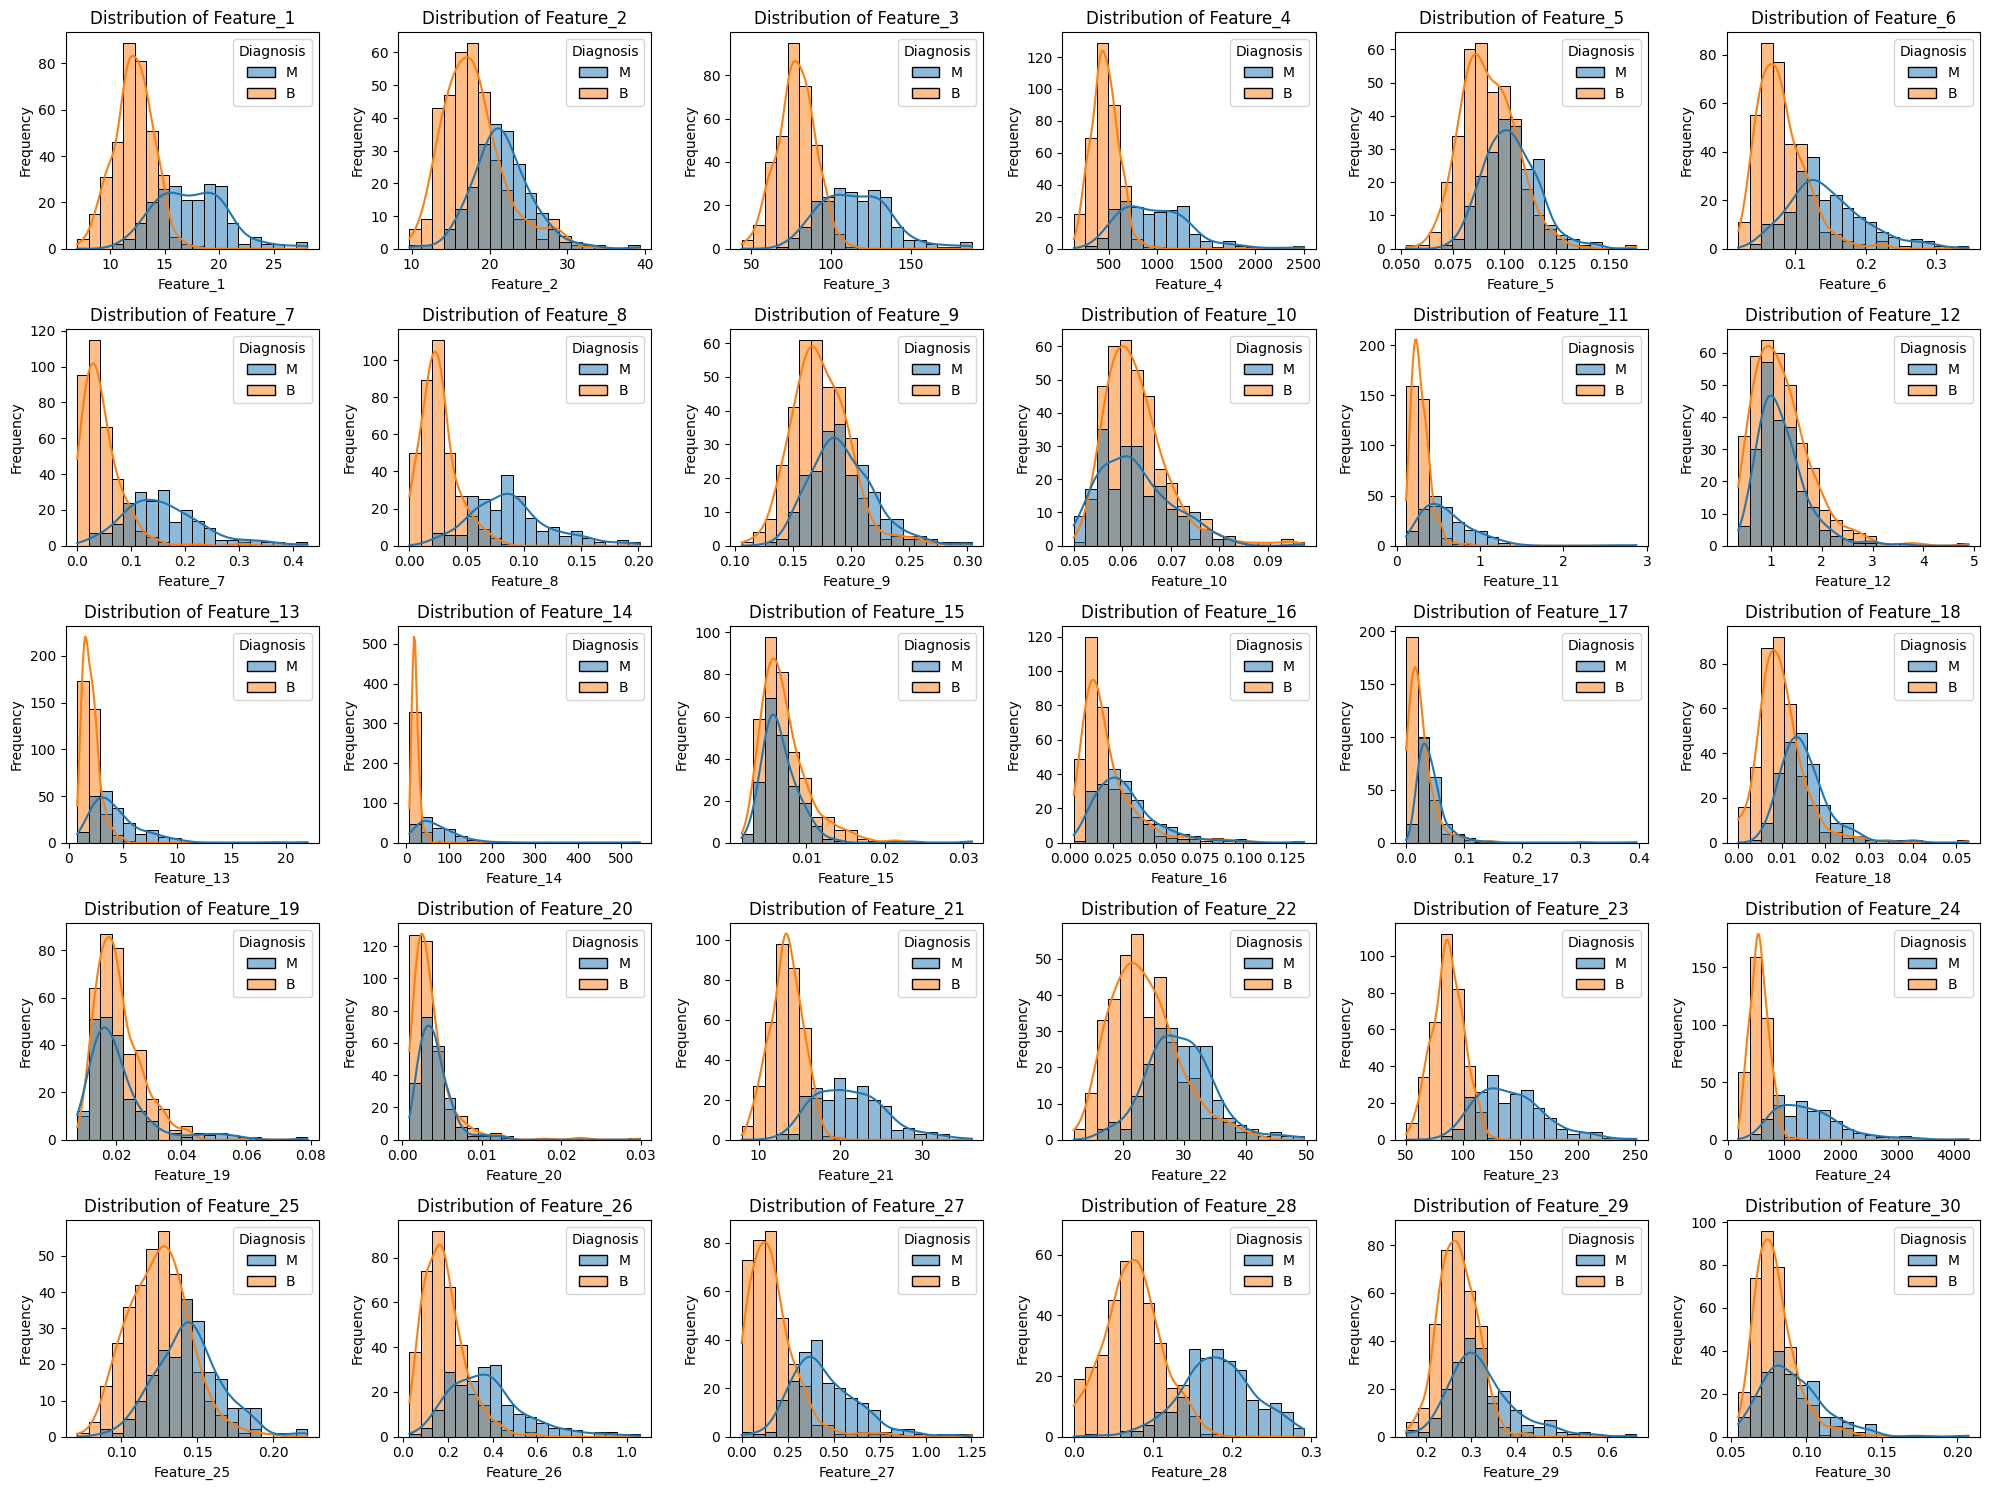

<ipython-input-2-3aeaba880f76>:35: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_data.corr()


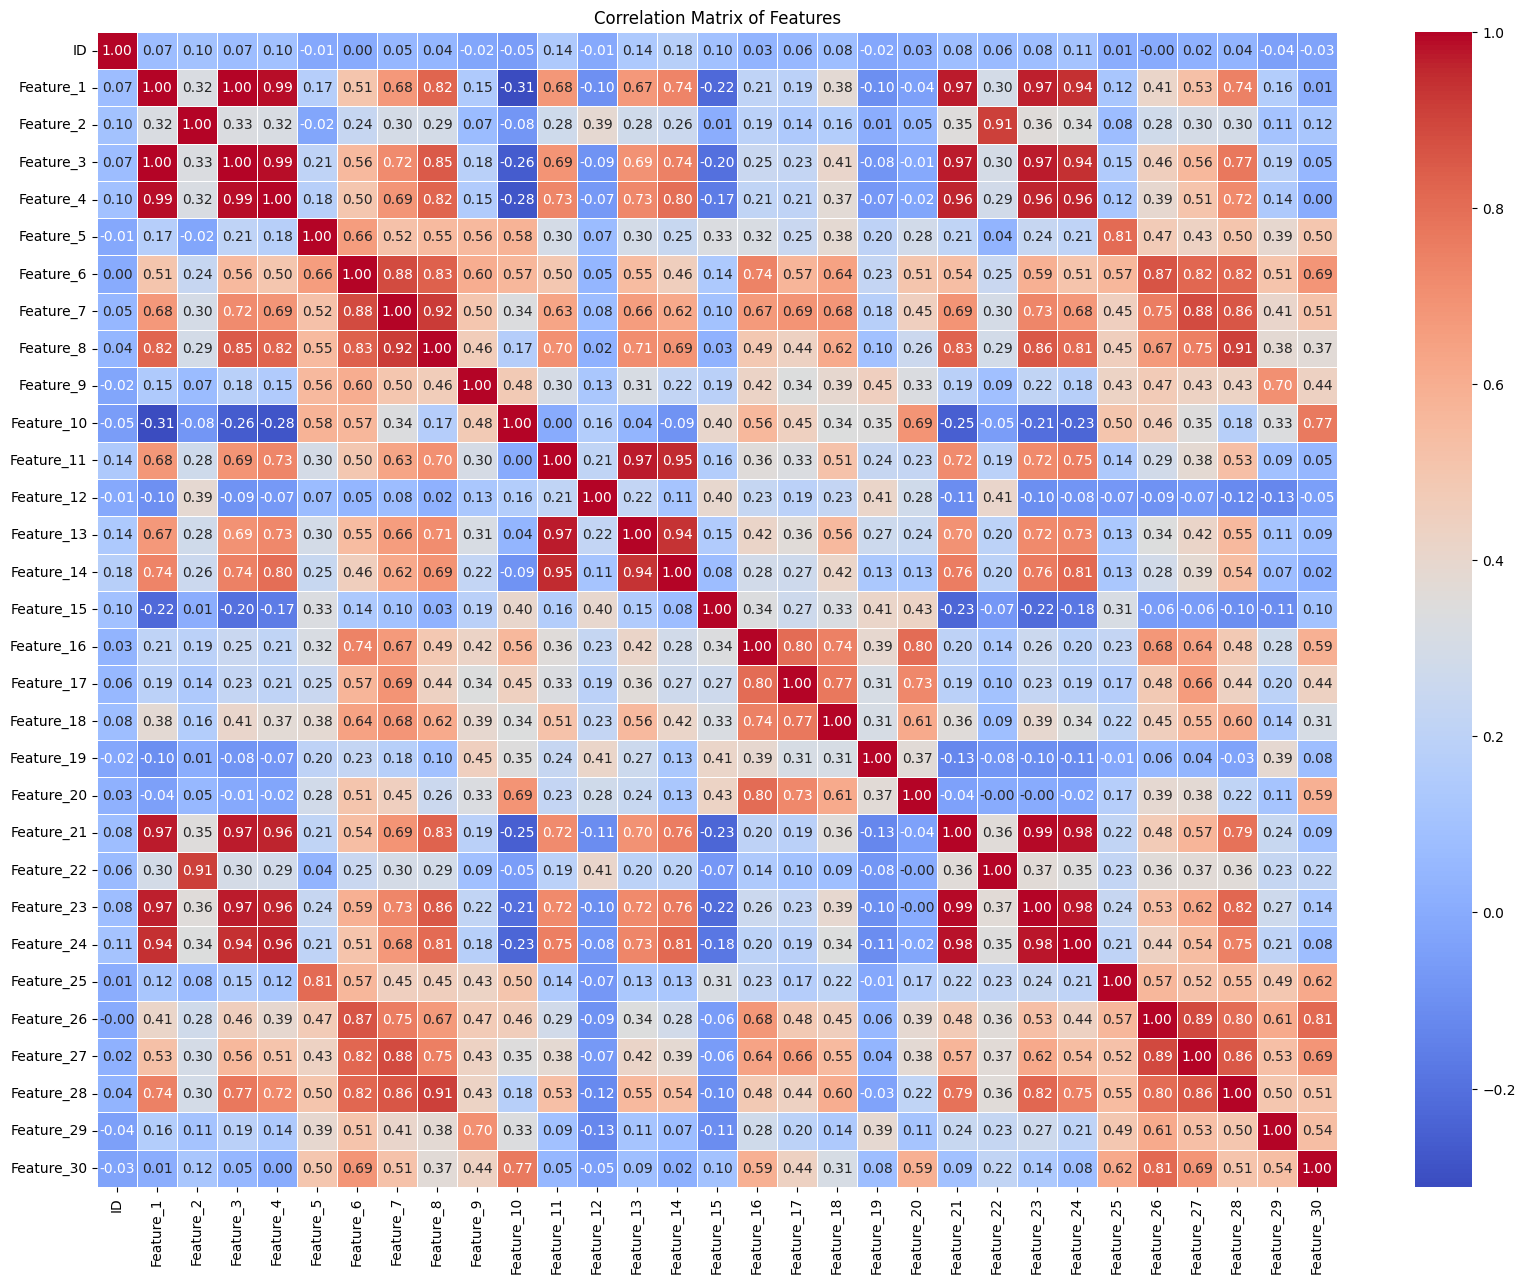

In [2]:
# Analyze class distribution
import seaborn as sns

Diagnosis_distribution = df_data['Diagnosis'].value_counts()
print("Diagnosis Distribution:")
print(Diagnosis_distribution)


# Visualize Diagnosis distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Diagnosis', data=df_data)
plt.title('Diagnosis Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
# Save the plot to a file
plt.savefig("Classes dist.png")
plt.show()

# Visualize distributions of all features with respect to diagnosis
plt.figure(figsize=(20, 15))
for i in range(1, 31):
    feature_name = f'Feature_{i}'
    plt.subplot(5, 6, i)
    sns.histplot(data=df_data, x=feature_name, hue='Diagnosis', kde=True, bins=20)
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
plt.tight_layout()
# Save the plot to a file
plt.savefig("Features distribution.png")
plt.show()


# Compute the correlation matrix
correlation_matrix = df_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
# Save the plot to a file
plt.savefig("Correlation Heat Map.png")
plt.show()

Points:

1- Variance is shigh. Data have high range out of [-1,1], making normalization necessary.

2- The corelation graph suggests using PCA, as the variance between correlations ar ehigh.

# Log Regression

In [11]:
#@title Logisctic Regression
# Define the dataset
import time

X = df_data.drop(['ID', 'Diagnosis'], axis=1).values
y = np.where(df_data['Diagnosis'] == 'M', 1, 0)

# Define different learning rates to test
learning_rates = [0.0001, 0.00001, 0.000001, 0.0000001]

class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, use_higher_order=False, regularization=None, regularization_strength=1):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.use_higher_order = use_higher_order
        self.regularization = regularization
        self.regularization_strength = regularization_strength

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)

            # Regularization
            if self.regularization == 'Lasso':
                dw += self.regularization_strength * np.sign(self.weights)
            elif self.regularization == 'Ridge':
                dw += self.regularization_strength * 2 * self.weights

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        if self.weights is None or self.bias is None:
            raise ValueError("Model is not trained yet. Please call fit method first.")

        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = np.where(y_predicted > 0.5, 1, 0)
        return y_predicted_cls

    def create_subsets(self, X):
        if self.use_higher_order:
            squared_X = np.square(X)
            X_with_squared = np.hstack((X, squared_X))
            return [X_with_squared]
        else:
            return [X]

    def evaluate_accuracy(self, X, y_true):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y_true)
        return accuracy

    def evaluate(self, X, y, k=10):
        accuracies = []
        subsets = self.create_subsets(X)
        for i, subset in enumerate(subsets):
            subset_accuracies = self.kfold_evaluate(subset, y, k)
            mean_accuracy = np.mean(subset_accuracies)
            accuracies.append(mean_accuracy)
            print(f"Mean Accuracy : {mean_accuracy}")
        return accuracies

    def kfold_evaluate(self, X, y, k):
        accuracies = []
        data_split = self.split_data(X, y, k)
        for fold_idx, (train_indices, test_indices) in enumerate(data_split, 1):
            X_train, y_train = X[train_indices], y[train_indices]
            X_test, y_test = X[test_indices], y[test_indices]
            self.fit(X_train, y_train)
            accuracy = self.evaluate_accuracy(X_test, y_test)
            accuracies.append(accuracy)
            print(f"Accuracy for Fold {fold_idx}: {accuracy}")
        return accuracies

    def split_data(self, X, y, k):
        data_split = []
        fold_size = X.shape[0] // k
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        for i in range(k):
            start = i * fold_size
            end = (i + 1) * fold_size
            if i == k - 1:
                end = X.shape[0]
            test_indices = indices[start:end]
            train_indices = np.concatenate((indices[:start], indices[end:]))
            data_split.append((train_indices, test_indices))
        return data_split

In [12]:
#@title Test 1: Baseline method (Normalization: False, Adding higher order feature: False, Regularizatin: False, PCA: False)
# Define a dictionary to store Baseline
Baseline = {'lr': [],
           'Mean Accuracy': [],
           'Elapsed Time (seconds)': []}

# Loop over learning rates
for lr in learning_rates:
    start_time = time.time()

    print(f"Evaluating for Learning Rate: {lr}")
    model = LogisticRegression(learning_rate=lr, use_higher_order=False, regularization=None, regularization_strength=1)  # regularization takes 1- None, 2- 'Lasso', 3- 'Ridge'
    accuracies = model.evaluate(X, y)
    mean_accuracy = np.mean(accuracies)
    Baseline['lr'].append(lr)
    Baseline['Mean Accuracy'].append(mean_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    Baseline['Elapsed Time (seconds)'].append(elapsed_time)
    print()

print()

# Display Baseline table
results_df = pd.DataFrame(Baseline)
print()

# Transpose the DataFrame to have learning rates in horizontal order
results_df_transposed = results_df.set_index('lr').T

# Display Baseline table without index numbers
print(results_df_transposed.to_string())

Evaluating for Learning Rate: 0.0001
Accuracy for Fold 1: 0.8035714285714286
Accuracy for Fold 2: 0.875
Accuracy for Fold 3: 0.9285714285714286
Accuracy for Fold 4: 0.8928571428571429
Accuracy for Fold 5: 0.9107142857142857
Accuracy for Fold 6: 0.8928571428571429
Accuracy for Fold 7: 0.9107142857142857
Accuracy for Fold 8: 0.9464285714285714
Accuracy for Fold 9: 0.9464285714285714
Accuracy for Fold 10: 0.8923076923076924
Mean Accuracy : 0.8999450549450551

Evaluating for Learning Rate: 1e-05
Accuracy for Fold 1: 0.8928571428571429
Accuracy for Fold 2: 0.9821428571428571
Accuracy for Fold 3: 0.9285714285714286
Accuracy for Fold 4: 0.8928571428571429
Accuracy for Fold 5: 0.9285714285714286
Accuracy for Fold 6: 0.9464285714285714
Accuracy for Fold 7: 0.9107142857142857
Accuracy for Fold 8: 0.8392857142857143
Accuracy for Fold 9: 0.9464285714285714
Accuracy for Fold 10: 0.9076923076923077
Mean Accuracy : 0.9175549450549451

Evaluating for Learning Rate: 1e-06
Accuracy for Fold 1: 0.875
Acc

In [13]:
#@title Test 2: Improvement (Normalization: True, Adding higher order feature: False, Regularizatin: False, PCA: False)

def normalize(X):

    #Normalize the input features to have zero mean and unit variance.
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    return X_normalized
X = normalize(X)


# Define a dictionary to store Normalized
Normalized = {'lr': [],
           'Mean Accuracy': [],
           'Elapsed Time (seconds)': []}

# Loop over learning rates
for lr in learning_rates:
    start_time = time.time()

    print(f"Evaluating for Learning Rate: {lr}")
    model = LogisticRegression(learning_rate=lr, use_higher_order=False, regularization=None, regularization_strength=1)  # regularization takes 1- None, 2- 'Lasso', 3- 'Ridge'
    accuracies = model.evaluate(X, y)
    mean_accuracy = np.mean(accuracies)
    Normalized['lr'].append(lr)
    Normalized['Mean Accuracy'].append(mean_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    Normalized['Elapsed Time (seconds)'].append(elapsed_time)
    print()

print()

# Display Normalized table
results_df = pd.DataFrame(Normalized)
print()
# Transpose the DataFrame to have learning rates in horizontal order
results_df_transposed = results_df.set_index('lr').T

# Display Baseline table without index numbers
print(results_df_transposed.to_string())

Evaluating for Learning Rate: 0.0001
Accuracy for Fold 1: 0.9642857142857143
Accuracy for Fold 2: 0.8928571428571429
Accuracy for Fold 3: 0.8928571428571429
Accuracy for Fold 4: 0.9107142857142857
Accuracy for Fold 5: 0.9642857142857143
Accuracy for Fold 6: 0.9107142857142857
Accuracy for Fold 7: 0.9642857142857143
Accuracy for Fold 8: 0.9821428571428571
Accuracy for Fold 9: 0.9107142857142857
Accuracy for Fold 10: 0.9538461538461539
Mean Accuracy : 0.9346703296703296

Evaluating for Learning Rate: 1e-05
Accuracy for Fold 1: 0.9642857142857143
Accuracy for Fold 2: 0.9285714285714286
Accuracy for Fold 3: 0.9464285714285714
Accuracy for Fold 4: 0.9464285714285714
Accuracy for Fold 5: 0.9285714285714286
Accuracy for Fold 6: 0.9821428571428571
Accuracy for Fold 7: 0.9107142857142857
Accuracy for Fold 8: 0.8571428571428571
Accuracy for Fold 9: 0.9642857142857143
Accuracy for Fold 10: 0.8923076923076924
Mean Accuracy : 0.932087912087912

Evaluating for Learning Rate: 1e-06
Accuracy for Fold 

In [14]:
#@title Test 3: Improvement (Normalization: True, Adding higher order feature: True, Regularizatin: False, PCA: False)

def normalize(X):

    #Normalize the input features to have zero mean and unit variance.
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    return X_normalized
X = normalize(X)

# Define a dictionary to store HOF
HOF = {'lr': [],
           'Mean Accuracy': [],
           'Elapsed Time (seconds)': []}

# Loop over learning rates
for lr in learning_rates:
    start_time = time.time()

    print(f"Evaluating for Learning Rate: {lr}")
    model = LogisticRegression(learning_rate=lr, use_higher_order=True, regularization=None, regularization_strength=1)  # regularization takes 1- None, 2- 'Lasso', 3- 'Ridge'
    accuracies = model.evaluate(X, y)
    mean_accuracy = np.mean(accuracies)
    HOF['lr'].append(lr)
    HOF['Mean Accuracy'].append(mean_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    HOF['Elapsed Time (seconds)'].append(elapsed_time)
    print()

print()

# Display HOF table
results_df = pd.DataFrame(HOF)
print()
# Transpose the DataFrame to have learning rates in horizontal order
results_df_transposed = results_df.set_index('lr').T

# Display Baseline table without index numbers
print(results_df_transposed.to_string())

Evaluating for Learning Rate: 0.0001
Accuracy for Fold 1: 0.9464285714285714
Accuracy for Fold 2: 0.8928571428571429
Accuracy for Fold 3: 0.8928571428571429
Accuracy for Fold 4: 0.9464285714285714
Accuracy for Fold 5: 0.9821428571428571
Accuracy for Fold 6: 0.9464285714285714
Accuracy for Fold 7: 0.9107142857142857
Accuracy for Fold 8: 0.9821428571428571
Accuracy for Fold 9: 0.9821428571428571
Accuracy for Fold 10: 0.9538461538461539
Mean Accuracy : 0.9435989010989012

Evaluating for Learning Rate: 1e-05
Accuracy for Fold 1: 0.9821428571428571
Accuracy for Fold 2: 0.9107142857142857
Accuracy for Fold 3: 0.8928571428571429
Accuracy for Fold 4: 0.9285714285714286
Accuracy for Fold 5: 0.9642857142857143
Accuracy for Fold 6: 0.9464285714285714
Accuracy for Fold 7: 0.9821428571428571
Accuracy for Fold 8: 0.9464285714285714
Accuracy for Fold 9: 0.9642857142857143
Accuracy for Fold 10: 0.8923076923076924
Mean Accuracy : 0.9410164835164835

Evaluating for Learning Rate: 1e-06
Accuracy for Fold

In [15]:
#@title Test 4: Improvement (Normalization: True, Adding higher order feature: False, Regularizatin: True, PCA: False)
def normalize(X):

    #Normalize the input features to have zero mean and unit variance.
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    return X_normalized
X = normalize(X)

# Define a dictionary to store Regularization
Regularization = {'lr': [],
           'Mean Accuracy': [],
           'Elapsed Time (seconds)': []}

# Loop over learning rates
for lr in learning_rates:
    start_time = time.time()

    print(f"Evaluating for Learning Rate: {lr}")
    model = LogisticRegression(learning_rate=lr, use_higher_order=False, regularization='Lasso', regularization_strength=1)  # regularization takes 1- None, 2- 'Lasso', 3- 'Ridge'
    accuracies = model.evaluate(X, y)
    mean_accuracy = np.mean(accuracies)
    Regularization['lr'].append(lr)
    Regularization['Mean Accuracy'].append(mean_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    Regularization['Elapsed Time (seconds)'].append(elapsed_time)
    print()

print()

# Display Regularization table
results_df = pd.DataFrame(Regularization)
print()
# Transpose the DataFrame to have learning rates in horizontal order
results_df_transposed = results_df.set_index('lr').T

# Display Baseline table without index numbers
print(results_df_transposed.to_string())

Evaluating for Learning Rate: 0.0001
Accuracy for Fold 1: 0.5892857142857143
Accuracy for Fold 2: 0.7142857142857143
Accuracy for Fold 3: 0.6785714285714286
Accuracy for Fold 4: 0.6071428571428571
Accuracy for Fold 5: 0.6428571428571429
Accuracy for Fold 6: 0.6964285714285714
Accuracy for Fold 7: 0.6428571428571429
Accuracy for Fold 8: 0.5178571428571429
Accuracy for Fold 9: 0.6071428571428571
Accuracy for Fold 10: 0.5846153846153846
Mean Accuracy : 0.6281043956043956

Evaluating for Learning Rate: 1e-05
Accuracy for Fold 1: 0.5535714285714286
Accuracy for Fold 2: 0.625
Accuracy for Fold 3: 0.6607142857142857
Accuracy for Fold 4: 0.625
Accuracy for Fold 5: 0.625
Accuracy for Fold 6: 0.6964285714285714
Accuracy for Fold 7: 0.5714285714285714
Accuracy for Fold 8: 0.6071428571428571
Accuracy for Fold 9: 0.6785714285714286
Accuracy for Fold 10: 0.6307692307692307
Mean Accuracy : 0.6273626373626374

Evaluating for Learning Rate: 1e-06
Accuracy for Fold 1: 0.6428571428571429
Accuracy for Fol

**PCA**

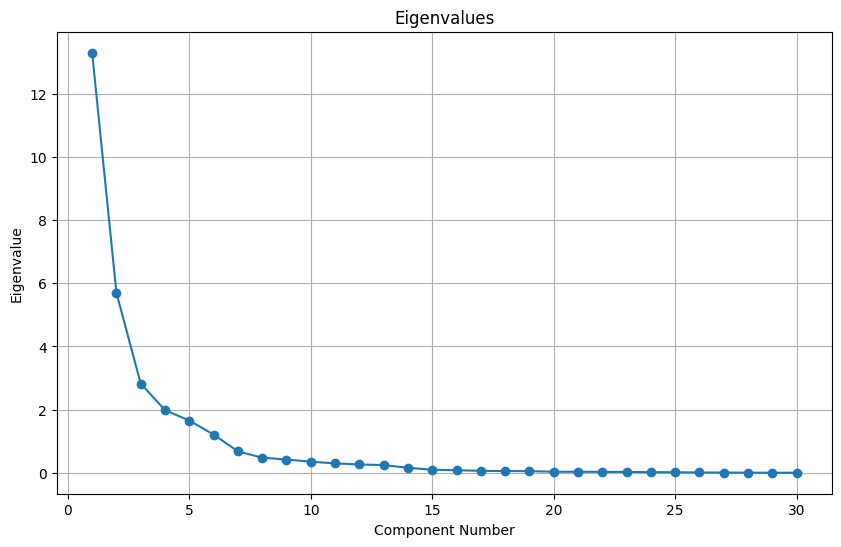

In [16]:
# apply PCA
# Step 1: Standardize the data
X = df_data.drop(['ID', 'Diagnosis'], axis=1).values
y = np.where(df_data['Diagnosis'] == 'M', 1, 0)

# Standardize the features
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_scaled = (X - X_mean) / X_std

'''# Step 2: Compute the covariance matrix
cov_matrix = np.cov(X_scaled.T)

# Step 3: Calculate the eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)'''

# Step 2: Compute the covariance matrix
def compute_covariance_matrix(X):
    n_samples = X.shape[0]
    cov_matrix = np.zeros((X.shape[1], X.shape[1]))
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            cov_matrix[i][j] = np.sum((X[:, i] - np.mean(X[:, i])) * (X[:, j] - np.mean(X[:, j]))) / (n_samples - 1)
    return cov_matrix

cov_matrix = compute_covariance_matrix(X_scaled)

# Step 3: Calculate the eigenvectors and eigenvalues
def calculate_eig(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

eigenvalues, eigenvectors = calculate_eig(cov_matrix)

# Step 4: Sort the eigenvalues in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Step 5: Select the top k eigenvectors
k = len(X[0])  # Assuming we keep all components for the plot
top_k_eigenvectors = eigenvectors[:, :k]

# Transform the original data onto the new feature subspace
X_pca = X_scaled.dot(top_k_eigenvectors)

# Plot the eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues')
plt.grid(True)
# Save the plot to a file
plt.savefig("eigenvalues_plot.png")

plt.show()

In [17]:
#@title Test 5: Improvement (Normalization: False, Adding higher order feature: True, Regularizatin: False, PCA: True)

# Define a dictionary to store PCA
PCA = {'lr': [],
           'Mean Accuracy': [],
           'Elapsed Time (seconds)': []}

# Define the number of top eigenvalues to keep (Hyper-parameter)
q = 10

# Create DataFrame with the subset of PCA-transformed features
X_pca_subset = pd.DataFrame(X_pca[:, :q], columns=[f'PC{i+1}_pca' for i in range(q)])

# Concatenate the original DataFrame with the PCA-transformed subset DataFrame
df_pca_subset = pd.concat([df_data[['ID', 'Diagnosis']], X_pca_subset], axis=1)



# Loop over learning rates
for lr in learning_rates:
    start_time = time.time()

    print(f"Evaluating for Learning Rate: {lr}")
    model = LogisticRegression(learning_rate=lr, use_higher_order=False, regularization=None, regularization_strength=1)  # regularization takes 1- None, 2- 'Lasso', 3- 'Ridge'
    accuracies = model.evaluate(X_pca_subset.values, y)
    mean_accuracy = np.mean(accuracies)
    PCA['lr'].append(lr)
    PCA['Mean Accuracy'].append(mean_accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time
    PCA['Elapsed Time (seconds)'].append(elapsed_time)
    print()

print()

# Display PCA table
results_df = pd.DataFrame(PCA)
print()

# Transpose the DataFrame to have learning rates in horizontal order
results_df_transposed = results_df.set_index('lr').T

# Display Baseline table without index numbers
print(results_df_transposed.to_string())

Evaluating for Learning Rate: 0.0001
Accuracy for Fold 1: 0.9285714285714286
Accuracy for Fold 2: 0.9285714285714286
Accuracy for Fold 3: 0.9464285714285714
Accuracy for Fold 4: 0.9285714285714286
Accuracy for Fold 5: 0.9107142857142857
Accuracy for Fold 6: 0.9285714285714286
Accuracy for Fold 7: 0.9642857142857143
Accuracy for Fold 8: 0.9285714285714286
Accuracy for Fold 9: 0.8928571428571429
Accuracy for Fold 10: 0.9846153846153847
Mean Accuracy : 0.9341758241758242

Evaluating for Learning Rate: 1e-05
Accuracy for Fold 1: 0.8571428571428571
Accuracy for Fold 2: 0.9285714285714286
Accuracy for Fold 3: 0.9285714285714286
Accuracy for Fold 4: 0.9464285714285714
Accuracy for Fold 5: 0.8928571428571429
Accuracy for Fold 6: 0.9464285714285714
Accuracy for Fold 7: 0.9821428571428571
Accuracy for Fold 8: 0.9285714285714286
Accuracy for Fold 9: 0.9821428571428571
Accuracy for Fold 10: 0.9384615384615385
Mean Accuracy : 0.9331318681318681

Evaluating for Learning Rate: 1e-06
Accuracy for Fold

In [18]:
#@title Overall Table of Results
# Combine results from results1 and results2
results_combined = pd.concat([pd.DataFrame(Baseline), pd.DataFrame(Normalized), pd.DataFrame(HOF), pd.DataFrame(PCA)], axis=1, keys=['Baseline', 'Normalized', 'HOF', 'PCA'])

# Transpose the DataFrame to have learning rates in horizontal order
results_combined_transposed = results_combined.T

# Display combined results table without index numbers
print(results_combined_transposed.to_string())

# Write the DataFrame to an Excel file
results_combined_transposed.to_excel("results.xlsx")

                                          0         1         2             3
Baseline   lr                      0.000100  0.000010  0.000001  1.000000e-07
           Mean Accuracy           0.899945  0.917555  0.906841  6.225549e-01
           Elapsed Time (seconds)  0.912241  1.066150  1.683239  1.714664e+00
Normalized lr                      0.000100  0.000010  0.000001  1.000000e-07
           Mean Accuracy           0.934670  0.932088  0.931099  9.333791e-01
           Elapsed Time (seconds)  0.885953  0.869336  0.852372  8.312371e-01
HOF        lr                      0.000100  0.000010  0.000001  1.000000e-07
           Mean Accuracy           0.943599  0.941016  0.943352  9.474176e-01
           Elapsed Time (seconds)  0.915901  0.880791  0.895873  9.089117e-01
PCA        lr                      0.000100  0.000010  0.000001  1.000000e-07
           Mean Accuracy           0.934176  0.933132  0.931593  9.303022e-01
           Elapsed Time (seconds)  0.528756  0.455995  0.433668 